# Dark matter shards of $\omega$ centauri
Taking the the velocities of the objects reported in https://arxiv.org/abs/1804.07050 and creating a composite velocity distribution from them

0 [  -8.6 -286.7  -67.9] [ 115.3   49.9   60. ]
1 [  54.1 -393.8   68.3] [ 147.2   45.7  149.4]
2 [  47.8 -254.6   71.8] [ 110.2   27.8  172.1]
3 [  28.  -275.1   18. ] [ 186.    62.7  136.5]
4 [ 177.6 -287.9  117.9] [ 114.6   46.   162.7]
5 [-10.  -82.3  -0.6] [  83.2   21.2  162.7]
6 [ -11.9 -222.1   88. ] [ 187.6   44.   134.9]
7 [ -92.3 -160.2  -33.4] [ 274.6   66.5  178.1]
8 [ -11.2  159.6 -166.5] [  65.6   21.9  151.7]
9 [-242.4  109.9  180.7] [ 229.2   35.9  236.1]
10 [   8.2  192.   -25. ] [ 124.    40.2  186.6]
11 [  48.4  164.5 -171.1] [ 139.6   24.2  172. ]
12 [-115.6   17.4  169.3] [ 200.3   18.5  197.5]
13 [-82.8  91.7  41.4] [ 171.1   36.6  239.8]
14 [-33.3  94.4  60.9] [ 175.4   26.8  197.5]
15 [-101.3   -9.3   98.4] [ 246.4   30.4  238.1]
16 [ -51.6  170.5   -7.5] [ 166.6   27.    90.1]
17 [ -73.6  186.4  -29.2] [ 285.9   34.7  129.2]
18 [ 114.6  107.3   90.7] [ 283.2   19.3  146.9]
19 [  29.    77.5  116.5] [ 201.1   13.2  269.9]
20 [-151.7   -8.3  -26.3] [ 424.7   40.

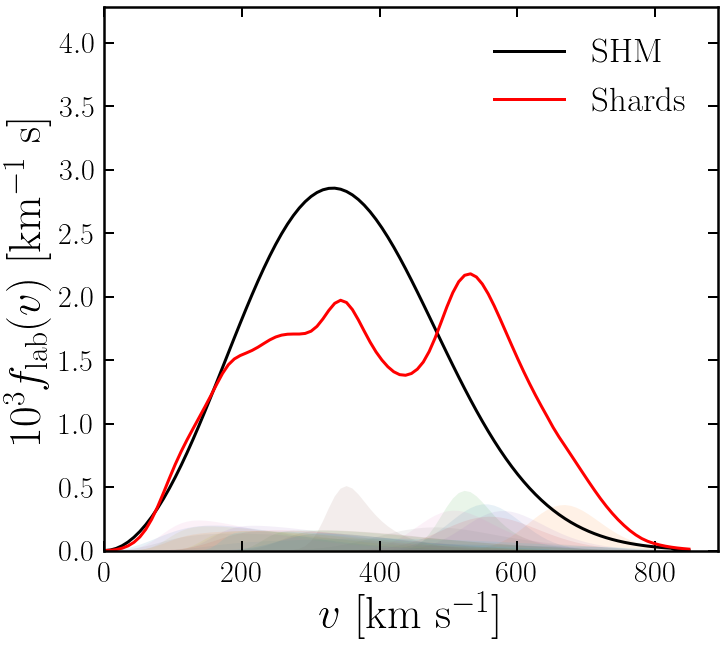

In [5]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Figure setup
fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(111)
pltname = 'Shards_fv'

# v range
n = 100
v = linspace(0,850.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
beta = HaloModel.SausageBeta
v_lab = LabVelocitySimple(67,HaloModel)

# Load shards
dat = loadtxt('../shards.txt',delimiter=',')

# Speed distributions
fv_Iso = SpeedDist_Isotropic(v,v_lab,v0,v_esc)
plt.plot(v,1e3*fv_Iso,'k-',linewidth=3,label=r'SHM')

nshards = 21
xi_s = 1.0/(1.0*nshards)
fv = zeros(shape=(nshards,n))
for i in range(0,nshards):
    v_s = dat[i,0:3]
    sig_s = dat[i,6:9]
    fv[i,:] = xi_s*SpeedDist_3D(v,(v_lab-v_s),sig_s)
    plt.fill_between(v,1e3*fv[i,:],linewidth=3,alpha=0.1)
    sigr = sig_s[0]
    sigphi = sig_s[1]
    sigz = sig_s[2]
    beta = 1.0-(sigr**2.0+sigz**2.0)/(2*sigr**2.0)
    print i,v_s,sig_s

plt.plot(v,1e3*sum(fv,0),'r-',linewidth=3,label=r'Shards')

# Plot fiddling
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0,top=max(1e3*fv_Iso)*1.5)
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xlabel(r"$v$ [km s$^{-1}$]",fontsize=45);
plt.ylabel(r"$10^3 f_{\rm lab}(v)$ [km$^{-1}$ s]",fontsize=45);
plt.legend(fontsize=35,frameon=False,loc='upper right')

# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Halo with spinning components
Adding a set of $N$ randomly generated sub-components to the halo with retrograde spins $v_{\rm spin}$ with an average retrograde circular motion of 50 km/s. The dispersions are Normally distributed with a mean of 70 km/s and std of 10 km/s. currently this assumes that the halo is made up of a fraction $\xi$ in these retrograde parts and the rest in a round component (no sausage yet here). The $\xi$ is split evenly amongst the $N$ substructures.

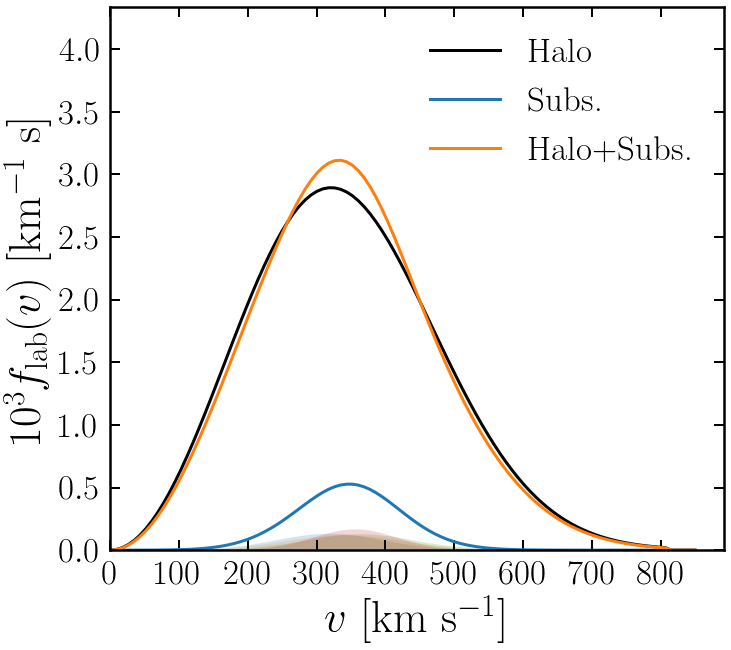

In [30]:
# Figure setup
fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(111)
pltname = 'SpinningSubs_fv'

# Galactic parameters
rho0 = 0.55
rho0_Msol_kpc3 = rho0*2.6e8
G = 4.3e-6
R0 = 8.0
Rs = 2.0
Mr = 4*pi*rho0_Msol_kpc3*Rs*3.0*(log((Rs+R0)/Rs)-(R0/(Rs+R0)))

# Number of substructures
N = 4

# Dispersions
sig_subs = abs(normal(loc=70.0,scale=10.0,size=N))
m_sub = 5e10
R_subs = G*m_sub/(2*sig_subs**2.0)
rho_subs = m_sub/(4*pi*R0**2.0*R_subs)
#xi = rho_subs/rho0_Msol_kpc3
xi = 0.1/N
xi0 = 1.0-xi*N

# Velocity components from spin parameter
#lamb = lognormal(mean=0.04, sigma=0.6, size=N)
#vt = sqrt(2.0)*lamb*v0*(Mr/m_sub)
#vt = normal(loc=50.0,scale=20.0,size=N)
#th = pi*(random(size=N)-0.5)
#vth = -1.0*vt*cos(th)
#vph = vt*sin(th)
#vr = normal(loc=0.0,scale=25.0,size=N)

# Velocty components from random retrograde vector 
vth = -1.0*normal(loc=50.0,scale=20.0,size=N)
vph = normal(loc=0.0,scale=50.0,size=N)
vr = normal(loc=0.0,scale=50.0,size=N)

# Add them all together
fv0 = SpeedDist_Isotropic(v,v_lab,v0,v_esc)
fvtot = xi0*fv0
for i in range(0,N):
    vspin = [vr[i],vth[i],vph[i]]
    fvsub = xi*SpeedDist_Isotropic(v,v_lab-vspin,sqrt(2.0)*sig_subs[i],v_esc)
    fvtot += fvsub
    plt.fill_between(v,1e3*fvsub,y2=0.0,alpha=0.2)
plt.plot(v,1e3*fv0,'k-',linewidth=3,label='Halo')
plt.plot(v,1e3*(fvtot-fv0*xi0),linewidth=3,label='Subs.')
plt.plot(v,1e3*fvtot,linewidth=3,label='Halo+Subs.')

# Plot fiddling
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0,top=max(1e3*fv0)*1.5)
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"$v$ [km s$^{-1}$]",fontsize=45);
plt.ylabel(r"$10^3 f_{\rm lab}(v)$ [km$^{-1}$ s]",fontsize=45);
plt.legend(fontsize=35,frameon=False,loc='upper right')

# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Annual modulation
Plot range and amplitude of the annual modulation

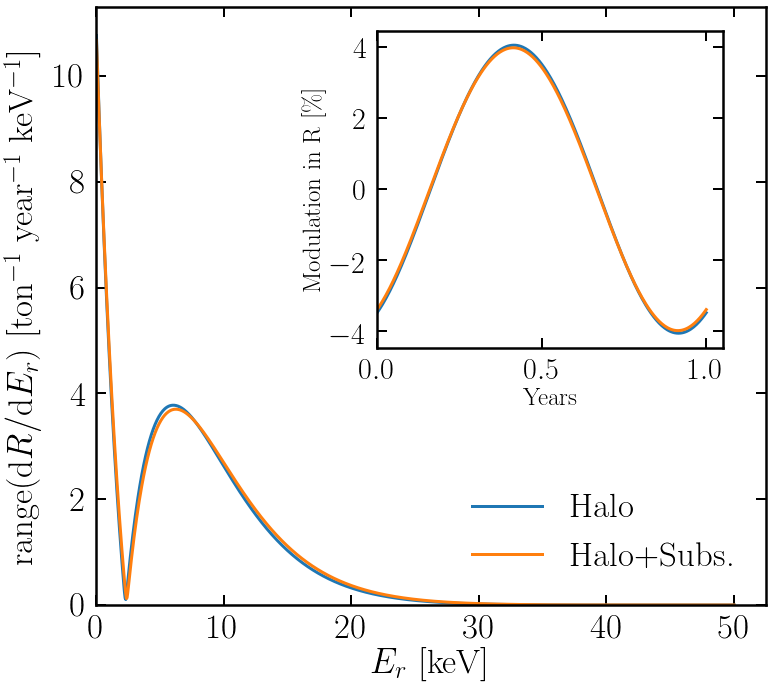

In [31]:
# DM params
A = Xe131.MassNumber
m_chi = 20.0
sigma_p = 1.0e-45

# Energy range
n = 1000
E_th = 2.0
E_max = 50.0
E = linspace(0.01,E_max,n)
v_min = MinimumWIMPSpeed(E,A,m_chi)

# Loop over times
ndays = 365
days = linspace(0,365,ndays)
dR0 = zeros(shape=(ndays,n))
dR = zeros(shape=(ndays,n))
R = zeros(shape=ndays)
R0 = zeros(shape=ndays)
for i in range(0,ndays):
    v_lab = LabVelocitySimple(days[i],HaloModel)
    gmin0 = gvmin_Isotropic(v_min,v_lab,v0,v_esc)
    gmin = xi0*gmin0
    for isub in range(0,N):
        v_spin = [vr[isub],vth[isub],vph[isub]]
        gmin += xi*gvmin_Isotropic(v_min,v_lab-v_spin,v0,v_esc)
        
    dR[i,:] = diffRecoilRate_SI(E,gmin,A,sigma_p,m_chi,rho_0=0.55)
    dR0[i,:] = diffRecoilRate_SI(E,gmin0,A,sigma_p,m_chi,rho_0=0.55)
    R[i] = trapz(dR[i,(E>E_th)],E[E>E_th])
    R0[i] = trapz(dR0[i,(E>E_th)],E[E>E_th])

Rdiff = zeros(shape=n)
Rdiff0 = zeros(shape=n)
for i in range(0,n):
    Rdiff[i] = max(dR[:,i])-min(dR[:,i])
    Rdiff0[i] = max(dR0[:,i])-min(dR0[:,i])
    
    
# Plot
fig = plt.figure(figsize=(12,11))
ax1 = fig.add_subplot(111)
left, bottom, width, height = [0.45, 0.45, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])


plt.sca(ax1)
plt.plot(E,Rdiff0,label='Halo',linewidth=3)
plt.plot(E,Rdiff,label='Halo+Subs.',linewidth=3)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"$E_r$ [keV]",fontsize=35);
plt.ylabel(r"range($\textrm{d}R/\textrm{d}E_r$) [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]" ,fontsize=35,labelpad=10);
plt.legend(fontsize=35,frameon=False,loc='lower right')

plt.sca(ax2)
R0mid = (max(R0)+min(R0))/2.0
Rmid = (max(R)+min(R))/2.0
plt.plot(days/365,100*(R0-R0mid)/R0mid,label='Halo',linewidth=3)
plt.plot(days/365,100*(R-Rmid)/Rmid,label='Halo+Subs.',linewidth=3)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"Years",fontsize=25);
plt.ylabel(r"Modulation in R [\%]" ,fontsize=25);

ax1.set_xlim(left=0.0)
ax1.set_ylim(bottom=0.0)
ax1.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10)
ax1.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax2.set_xlim(left=0.0)
ax2.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax2.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)


plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Axion spectrum

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in divide


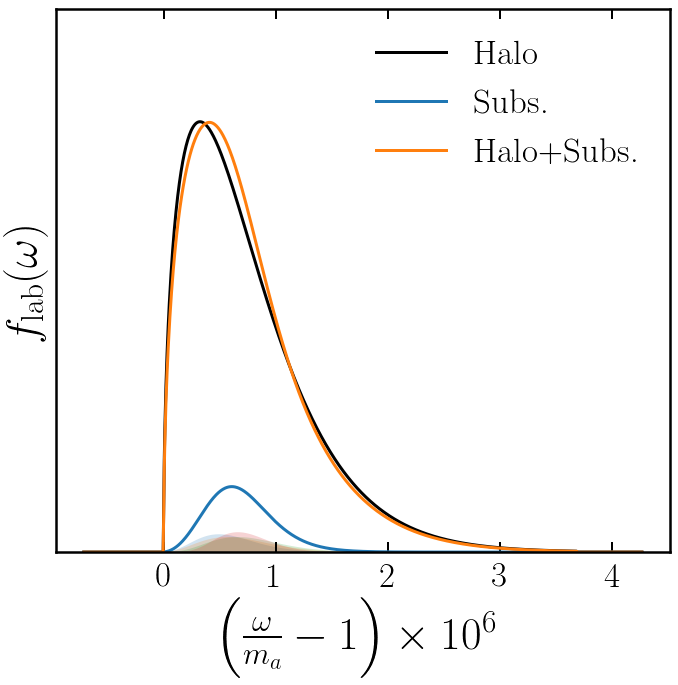

In [37]:
# Figure setup
fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(111)
pltname = 'SpinningSubs_axionspectrum'

c_km = 3e8/1000

# Axion mass
m_a = 3e-6
m_a_s = m_a/6.58e-16


# Converting frequency to speed
n = 1000
vmin = 0.1
vmax = 800
omega_min = (m_a_s)*(1+(vmin/c_km)**2.0/2.0)
omega_max = (m_a_s)*(1+(vmax/c_km)**2.0/2.0)
axionBW = (omega_max-omega_min)
omega = linspace(omega_min-0.2*axionBW,omega_max+0.2*axionBW,n)
omega_min = omega[0]
omega_max = omega[-1]
domega = omega[1]-omega[0]
v = c_km*sqrt(2*(omega-m_a_s)/omega)
v[omega<m_a_s] = 0.0
dv = (1.0/m_a_s)*(c_km/v)*c_km
dv[omega<m_a_s] = 0.0

x = 1e6*(omega/m_a_s-1)
ys = domega*dv

# Plot power spectra
v_lab = LabVelocitySimple(0.0,HaloModel)
fv0 = SpeedDist_Isotropic(v,v_lab,v0,v_esc)
fvtot = xi0*fv0
for i in range(0,N):
    vspin = [vr[i],vth[i],vph[i]]
    fvsub = xi*SpeedDist_Isotropic(v,v_lab-vspin,sqrt(2.0)*sig_subs[i],v_esc)
    fvtot += fvsub
    plt.fill_between(x,ys*fvsub,y2=0.0,alpha=0.2)
plt.plot(x,ys*fv0,'k-',linewidth=3,label='Halo')
plt.plot(x,ys*(fvtot-fv0*xi0),linewidth=3,label='Subs.')
plt.plot(x,ys*fvtot,linewidth=3,label='Halo+Subs.')



# Plot fiddling
ax.set_ylim(bottom=0.0,top=max(fv0)*2)
ax.tick_params(which='major',direction='in',width=2,length=10,left=False,top=True,pad=10,labelleft=False)
plt.xticks(fontsize=35)
plt.xlabel(r"$\left(\frac{\omega}{m_a} -1\right)\times 10^6$",fontsize=45);
plt.ylabel(r"$f_{\rm lab}(\omega)$",fontsize=45);
plt.legend(fontsize=35,frameon=False,loc='upper right')

# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Directional signal

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING: x coordinate not montonically increasing - contour plot
may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING: x coordinate not montonically increasing - contour plot
may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see

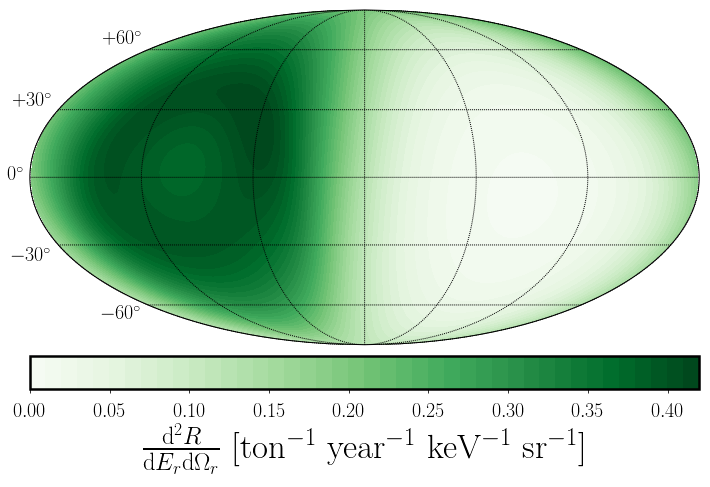

In [56]:
import warnings
warnings.filterwarnings("ignore", module="mpl_toolkits.basemap")
fig = plt.figure(figsize=(12,10))
pltname = 'SpinningSubs_Directional'

n = 200
ph = linspace(-pi, pi, n)
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

# Benchmark
E = 5.0
m_chi = 20.0
sigma_p = 1.0e-45
A = F19.MassNumber
v_min = MinimumWIMPSpeed(E,A,m_chi)

# Radon transform and rate
fhat = xi0*fhat_Isotropic(v_min,-1.0*q,v_lab,v0,v_esc)
for i in range(0,N):
    vspin = [vr[i],vth[i],vph[i]]
    fhat += xi*fhat_Isotropic(v_min,-1.0*q,v_lab-vspin,sqrt(2.0)*sig_subs[i],v_esc)
dR = diffRecoilRate_SI(E,fhat,A,sigma_p,m_chi)

# Convert list into Mollweide map
dR_map = zeros(shape=(n/2,n))
ii = 0
for i in range(0,n/2):
    for j in range(0,n):
        dR_map[i,j] = dR[ii]
        ii = ii+1
dR_map = flipud(dR_map)        

# Plot map
m = Basemap(projection='moll',lon_0=180.0,resolution='c',celestial=True)
for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map,50, cmap=plt.cm.Greens,latlon=True)
m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians

# colorbar
cbar = plt.colorbar(orientation='horizontal',pad=0.02)
cbar.ax.tick_params(labelsize=20,pad=10)
cbar.set_label(r'$\frac{{\rm d}^2 R}{{\rm d}E_r {\rm d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$ sr$^{-1}$]',fontsize=35,labelpad=10)
plt.show()

# save figure
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')